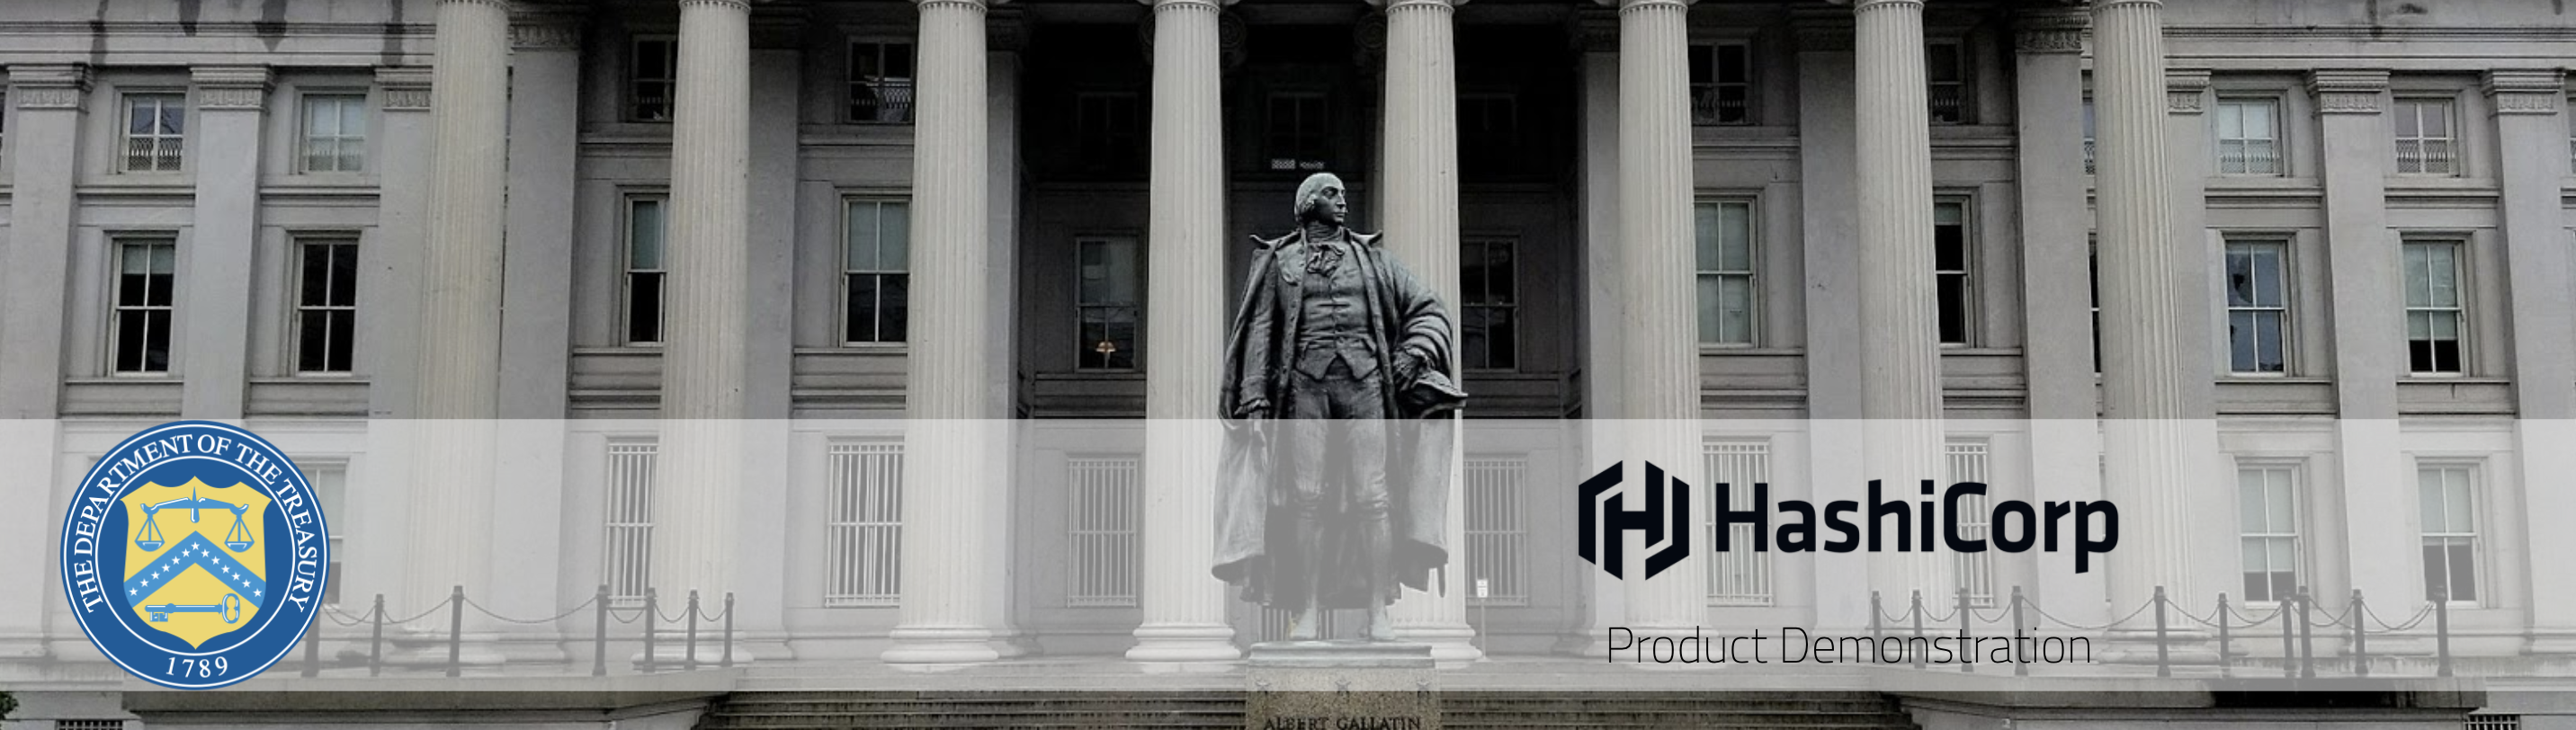

---


# UC-4 App Role Authentication
---

## Business Value of Capability
 * Provide a way for operators to manage policy without being involved in generating tokens or creds for applications (minimize co-ordination) 
 * Operators have less work to do
 * Orchestration tools can take over the task of giving applications secrets access
 
### Prerequisites
* Running Vault Enterprise instance (even in dev mode)

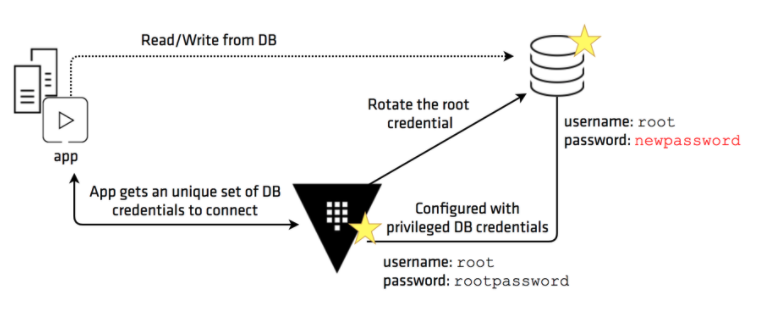

### Setup
---

In [2]:
export VAULT_ADDR=http://127.0.0.1:8200
export VAULT_TOKEN=root
export VAULT_SKIP_VERIFY=true
export LICENSE=/Users/jnyika/.licenses/vault.json

In [3]:
vault login root

WARNING! The VAULT_TOKEN environment variable is set! This takes precedence
over the value set by this command. To use the value set by this command,
unset the VAULT_TOKEN environment variable or set it to the token displayed
below.

Success! You are now authenticated. The token information displayed below
is already stored in the token helper. You do NOT need to run "vault login"
again. Future Vault requests will automatically use this token.

Key                  Value
---                  -----
token                root
token_accessor       KEIFPGXrOIg23OiXHydrOyap
token_duration       ∞
token_renewable      false
token_policies       ["root"]
identity_policies    []
policies             ["root"]


In [24]:

curl --header "X-Vault-Token: root" \
 http://127.0.0.1:8200/v1/sys/health | jq -r

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   298  100   298    0     0  59600      0 --:--:-- --:--:-- --:--:-- 59600
{
  "initialized": true,
  "sealed": false,
  "standby": false,
  "performance_standby": false,
  "replication_performance_mode": "disabled",
  "replication_dr_mode": "disabled",
  "server_time_utc": 1620053702,
  "version": "1.6.2+ent",
  "cluster_name": "vault-cluster-a5a10455",
  "cluster_id": "b2e28c53-5f62-0b41-3c50-df81bfd31ec2"
}


In [5]:
vault -version

Vault v1.7.1 (917142287996a005cb1ed9d96d00d06a0590e44e)


In [6]:
#license
curl \
  --header "X-Vault-Token: root" \
  --request PUT \
  --data "@${LICENSE}" \
  http://127.0.0.1:8200/v1/sys/license

### Demo
---

**Create a new policy to govern this use case**  

In [7]:
echo '
path "auth/token/*" {
  capabilities = [ "create", "read", "update", "delete", "sudo" ]
}

# Manage secret/dev secret engine - for Verification test
path "secret/dev" {
  capabilities = [ "read" ]
}

# Manage secret/dev secret engine - for Verification test
path "secret/mysecret" {
  capabilities = [ "read" ]
}

path "auth/approle/role/application/role-id" {
  capabilities = ["read"]
}

path "auth/approle/role/application/secret-id" {
  capabilities = ["update"]
}

path "auth/approle/login" {
  capabilities = [ "create", "read"]
}

path "application/" {
  capabilities = ["list"]
}

path "application/*" {
  capabilities = ["list", "read"]
}' | vault policy write apps-policy -



Success! Uploaded policy: apps-policy


**Enable the approle authentication method**


In [8]:
vault auth enable approle

Success! Enabled approle auth method at: approle/


In [9]:
# Create a policy for our role myapp
vault write auth/approle/role/myapp policies="apps-policy" secret_id_num_uses=5 secret_id_ttl=5m

Success! Data written to: auth/approle/role/myapp


In [10]:
# Readback
vault read auth/approle/role/myapp

Key                        Value
---                        -----
bind_secret_id             true
local_secret_ids           false
policies                   [apps-policy]
secret_id_bound_cidrs      <nil>
secret_id_num_uses         5
secret_id_ttl              5m
token_bound_cidrs          []
token_explicit_max_ttl     0s
token_max_ttl              0s
token_no_default_policy    false
token_num_uses             0
token_period               0s
token_policies             [apps-policy]
token_ttl                  0s
token_type                 default


**Get a role id (this is usually NOT changing - pass this to developer of app)**  

In [11]:
vault read auth/approle/role/myapp/role-id

Key        Value
---        -----
role_id    88a3325a-5dfb-a4fb-5a50-578a1e684774


**Attempt to read the role id using the API**. 


In [12]:
export APPROLE="myapp"
ROLE_ID=$(curl -H "X-Vault-Token: ${VAULT_TOKEN}" "http://127.0.0.1:8200/v1/auth/approle/role/${APPROLE}/role-id" | jq -r '.data.role_id')
echo $ROLE_ID

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   208  100   208    0     0  34666      0 --:--:-- --:--:-- --:--:-- 34666
88a3325a-5dfb-a4fb-5a50-578a1e684774


**Generate a Secret ID**  

In [13]:
vault write -f auth/approle/role/myapp/secret-id

Key                   Value
---                   -----
secret_id             9e958a01-8dd6-ad65-4a1a-037447616623
secret_id_accessor    d929a12f-35a4-5dcb-4250-23e4ee087e4d


**Generate a Secret ID using CURL instead**  

In [14]:
SECRET_ID=$(curl -X POST -H "X-Vault-Token:${VAULT_TOKEN}" "http://127.0.0.1:8200/v1/auth/approle/role/${APPROLE}/secret-id" | jq -r '.data.secret_id')
echo ${SECRET_ID}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   270  100   270    0     0  45000      0 --:--:-- --:--:-- --:--:-- 45000
a408ccc2-6e6c-b075-678b-64206292ab70


**Write a new login with role id and secret id from to get the token for logging into vault**  

In [15]:
vault write auth/approle/login role_id=${ROLE_ID} \
  secret_id=${SECRET_ID}


Key                     Value
---                     -----
token                   s.wnhHvsRPJKLn6aAnVrH8t8od
token_accessor          gHfHc7VTCWIu2Ktc4FOKVhe4
token_duration          768h
token_renewable         true
token_policies          ["apps-policy" "default"]
identity_policies       []
policies                ["apps-policy" "default"]
token_meta_role_name    myapp


**Again, we can do the same using CURL**

In [16]:
APP_ROLE_TOKEN=$(curl -X POST -d '{"role_id": "'"${ROLE_ID}"'", "secret_id": "'"${SECRET_ID}"'"}' http://127.0.0.1:8200/v1/auth/approle/login | jq -r '.auth.client_token')
echo ${APP_ROLE_TOKEN}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   588  100   484  100   104  69142  14857 --:--:-- --:--:-- --:--:-- 84000
s.XEb8zHWGgjphOhIoBb8cSt0V


**Demonstrate login to UI using the AppRole Token**

In [17]:
vault login ${APP_ROLE_TOKEN}

WARNING! The VAULT_TOKEN environment variable is set! This takes precedence
over the value set by this command. To use the value set by this command,
unset the VAULT_TOKEN environment variable or set it to the token displayed
below.

Success! You are now authenticated. The token information displayed below
is already stored in the token helper. You do NOT need to run "vault login"
again. Future Vault requests will automatically use this token.

Key                     Value
---                     -----
token                   s.XEb8zHWGgjphOhIoBb8cSt0V
token_accessor          pTKceoiXgWRokfKpuzLqviLw
token_duration          767h59m57s
token_renewable         true
token_policies          ["apps-policy" "default"]
identity_policies       []
policies                ["apps-policy" "default"]
token_meta_role_name    myapp


In [18]:
vault auth disable approle

Success! Disabled the auth method (if it existed) at: approle/


**END**